In [1]:
from PIL import Image
import os

import matplotlib

import math
import h5py

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import scipy.misc

from sklearn.metrics import jaccard_score 
import tensorflow as tf
import re

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

## Setting paths for logits, ground truth and post processed

In [2]:
#result_path = "/home/pf/pfshare/data/MA_Rajanie/Post_processing_filter/Result/processed_raw"
logits_path= "/home/pf/pfshare/data/MA_Rajanie/models/research/deeplab/datasets/lake/exp/PTZ_and_nonPTZ_cam0/Test/Moritz_cam1_16-17/logits"
labels_path = "/home/pf/pfshare/data/MA_Rajanie/Post_processing_filter/Result/labels_raw_cam0"

## Creating numpy arrays


In [ ]:
files = (glob.glob(logits_path + "/*"))
files = (sorted(files))
logits=np.array([np.array(np.load(file)) for file in files])

In [4]:
print(logits.shape)
logits = logits[:-2]
print(logits.shape)

(1180, 393250, 5)
(1178, 393250, 5)


In [5]:
labels = (glob.glob(labels_path+ "/*"))
labels = (sorted(labels))
labels = np.array([np.array((Image.open(fname)).resize((1210,325))) for fname in labels])

In [7]:
labels=labels.reshape((labels.shape[0],-1))

In [8]:
print(labels.shape)
print(logits.shape)


(1178, 393250)
(1178, 393250, 5)


In [8]:
# n = 200  # for 2 random indices
# index = np.random.choice(labels.shape[0], n, replace=False)  

# x_random = logits[index]
# y_random = labels[index]

In [9]:
logits_1=logits.reshape((-1,5))
labels_1=labels.reshape((-1))

In [10]:
print(logits_1.shape)
print(labels_1.shape)
preds=np.argmax(logits_1,axis=1)
print(preds.shape)

(463248500, 5)
(463248500,)
(463248500,)


In [11]:
labels_onehot = np.eye(5)[labels_1]
print(labels_onehot.shape)
logits_onehot = np.eye(5)[preds]
print(logits_onehot.shape)

(463248500, 5)
(463248500, 5)


## Precision Recall Curve for each class 

In [12]:
np.save("labels.npy", labels_onehot)
np.save("logits.npy", logits_onehot)

In [2]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sys import getsizeof

n_classes=5
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    labels = np.load("labels.npy").astype(np.uint8)
    labels_onehot = labels[:, i]
    print(getsizeof(labels))
    del labels
    logits = np.load("logits.npy").astype(np.uint8)
    logits_onehot = logits[:, i]
    del logits
    
    precision[i], recall[i], _ = precision_recall_curve(labels_onehot,
                                                        logits_onehot)
    
    print(precision[i], recall[i])
    average_precision[i] = average_precision_score(labels_onehot, logits_onehot)
    print(average_precision[i])

# A "micro-average": quantifying score on all classes jointly

# labels = np.load("labels.npy")
# logits = np.load("logits.npy")
# precision["micro"], recall["micro"], _ = precision_recall_curve(labels.ravel(),
#     logits.ravel())
# average_precision["micro"] = average_precision_score(labels, logits,
#                                                      average="micro")
# print('Average precision score, micro-averaged over all classes: {0:0.2f}'
#       .format(average_precision["micro"]))

2316242612
[6.47600586e-09 0.00000000e+00 1.00000000e+00] [1. 0. 0.]
6.476005858626633e-09
2316242612
[0.47380683 0.9989249  1.        ] [1.         0.76199703 0.        ]
0.8739452395048198
2316242612
[0.08757537 0.4184508  1.        ] [1.         0.99398928 0.        ]
0.4164619996925848
2316242612
[0.35649314 0.9497547  1.        ] [1.        0.8732057 0.       ]
0.8745325108754174
2316242612
[0.08212465 0.69414091 1.        ] [1.         0.82761029 0.        ]
0.5886356042861898


KeyboardInterrupt: 

In [4]:
from inspect import signature
plt.figure()
step_kwargs=({'step':'post'}
            if 'step' in signature(plt.fill_between).parameters
            else {})
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b',
                 **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))


KeyError: 'micro'

<Figure size 432x288 with 0 Axes>

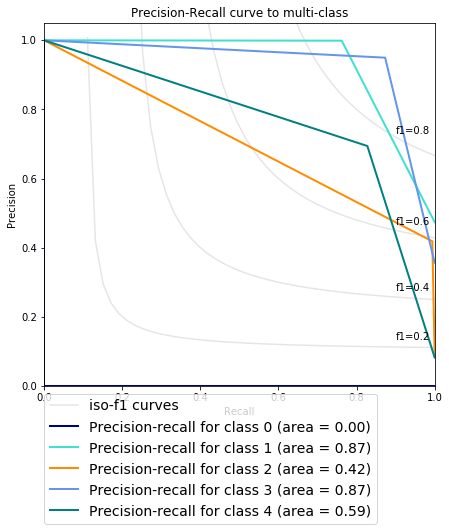

In [3]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

n_classes=5
plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
#l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
#lines.append(l)
#labels.append('micro-average Precision-recall (area = {0:0.2f})'
#              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

## Getting original labels ice on/off

In [13]:


def iceonoff(labels_path):
    dates = []
    all_dates = []
    dictionary = {}
    per_day_analysis=[]
    per_image_analysis=[]
    files = (glob.glob(labels_path + "/*"))
    files = (sorted(files))
    for file in files:
        im=Image.open(file)
        match=re.search(r'\d{4}_\d{4}', file).group()
    
        water = frozen = 0
        extra=0
        pixels = list(im.getdata())
        for i in pixels:
            if i==1:
                water+=1
            elif i==2 or i==3 or i==4:
                frozen+=1
            else:
                extra=1
            
        lake = water+frozen
        coverage=round(float(frozen/lake),2)
    
        per_image_analysis.append(coverage)
        all_dates.append(match)
    
        if match in dictionary.keys():
            dictionary[match].append(coverage)
        else:
            dictionary[match]=[coverage]
    
    for key, values in dictionary.items():
        dates.append(key)
        per_day_analysis.append(np.median(values))
        
    return all_dates, dates, per_day_analysis, per_image_analysis
    

In [14]:
labels_path = "labels_cam1_raw"
pred_path = "cam1_predicted"
all_dates, dates, per_day_analysis, per_image_analysis = iceonoff(labels_path)
all_dates, dates_pred, per_day_analysis_pred, per_image_analysis_pred = iceonoff(pred_path)


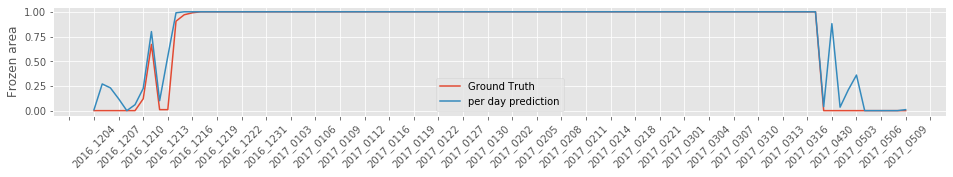

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.ticker as plticker
plt.style.use('ggplot')

fig = plt.figure(figsize=(16,2))
ax = fig.add_subplot()
#fig, ax = plt.subplots()
ax.plot(dates[:-30], per_day_analysis[:-30], label="Ground Truth" )
ax.plot(dates[:-30], per_day_analysis_pred[:-30], label="per day prediction")
loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.legend(loc='best')
plt.xticks(rotation=45)
plt.ylabel("Frozen area")
plt.show()


plt.savefig('cam1per_day.png')



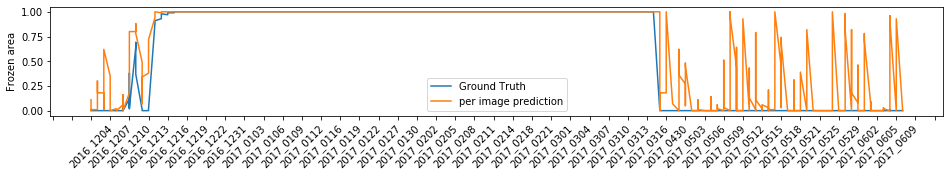

<Figure size 432x288 with 0 Axes>

In [190]:
import matplotlib.ticker as plticker
from scipy.ndimage.filters import median_filter

fig = plt.figure(figsize=(16,2))
ax = fig.add_subplot()
#fig, ax = plt.subplots()
ysmoothed=median_filter(per_image_analysis_pred[:-30], size=5)

ax.plot(all_dates[:-30], per_image_analysis[:-30], label="Ground Truth" )
ax.plot(all_dates[:-30], ysmoothed, label="per image prediction", markevery=100)
loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.legend(loc='best')
plt.xticks(rotation=45)
plt.ylabel("Frozen area")
plt.show()


plt.savefig('cam1.png')



## Applying median filter 

In [171]:
#Params
temporal=5

In [23]:
def median_filter(logits_path):
    logit_files = (glob.glob(logits_path + "/*"))
    logit_files = (sorted(logit_files))
    #logits=np.array([np.array(np.load(file)) for file in logit_files])
    dates = []
    all_dates = []
    dictionary = {}
    per_day_analysis_with_median=[]
    per_image_analysis_with_median=[]
    per_image_analysis_with_median = []
    
    i = 3
    
    for file in logit_files:
        match=re.search(r'\d{4}_\d{4}', file).group()
        #print(match)
        
        imgs = np.array([np.array(np.load(file)) for file in logit_files[i-3:i+4]])
        #print(imgs.shape)  
        
        i=i+1
        
    #for i in range(5, len(logit_files)-temporal):
        
        #pre_pixels= np.argmax(logits[i], axis=1)
        #imgs = logits[i-5:i+6]
        
        med = np.median(imgs, axis=0) 
        post_pixels = np.argmax(med, axis=1)
        
        water=frozen=extra=0
        
        for j in post_pixels:
            if j==1:
                water+=1
            elif j==2 or j==3 or j==4:
                frozen+=1
            else:
                extra=1
            
        lake = water+frozen
        coverage=round(float(frozen/lake),2)
        #print(coverage)
        per_image_analysis_with_median.append(coverage)
        all_dates.append(match)
    
        if match in dictionary.keys():
            dictionary[match].append(coverage)
        else:
            dictionary[match]=[coverage]
    
    for key, values in dictionary.items():
        dates.append(key)
        per_day_analysis_with_median.append(np.median(values))
        
        
        
    return dates, per_day_analysis_with_median

In [9]:
logits_path = "logits"
#print(logits.shape)


In [24]:
dates, per_day_analysis_with_median = median_filter(logits_path)

In [11]:
print(len(per_day_analysis_with_median))

130


## Post median filter

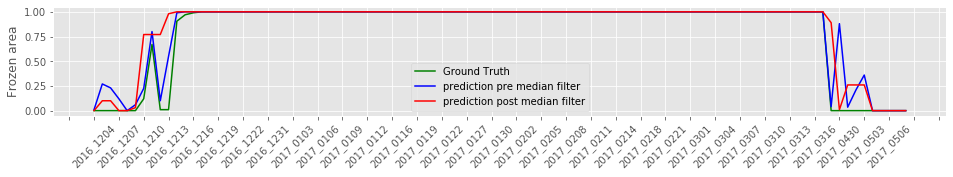

In [31]:
import matplotlib.ticker as plticker
from scipy.ndimage.filters import median_filter
plt.style.use('ggplot')


fig = plt.figure(figsize=(16,2))
ax = fig.add_subplot()
#fig, ax = plt.subplots()
ysmoothed_median=median_filter(per_day_analysis_with_median[:-31], size=3)

ax.plot(dates[:-31], per_day_analysis[:-31], label="Ground Truth", color="green")
ax.plot(dates[:-31], per_day_analysis_pred[:-31], label="prediction pre median filter", color="blue")
ax.plot(dates[:-31], ysmoothed_median, label="prediction post median filter",color="red")
loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.legend(loc='best')
plt.xticks(rotation=45)
plt.ylabel("Frozen area")
plt.show()



#### with temporal=2: Improvement on Moritz nonPTZ Cam 1 16-17
##### 0.75
##### 0.79

#### with temporal=3: Improvement on Moritz nonPTZ Cam 1 16-17
##### 0.75
##### 0.80

In [ ]:
with tf.Session() as sess:
    with tf.device('/cpu:0'):
        print(logits.shape)
        pre_pixels= np.argmax(logits, axis=2)
        ytrueT = tf.convert_to_tensor(labels, np.float32)
        ypredT = tf.convert_to_tensor(pre_pixels, np.float32)
        iou,conf_mat = tf.metrics.mean_iou(ytrueT, ypredT, num_classes=5)
        sess.run(tf.local_variables_initializer())
        sess.run([conf_mat])
        miou = sess.run([iou])
        print(miou)
#     for i in range(2, len(files)-temporal):
        
#         pre_pixels= np.argmax(logits[i], axis=1)
#         imgs = logits[i-2:i+3]
#         med = np.median(imgs, axis=0)        
#         post_pixels = np.argmax(med, axis=1)
#         ytrueT = tf.convert_to_tensor(labels[i], np.float32)
#         ypredT = tf.convert_to_tensor(pre_pixels, np.float32)
#         iou,conf_mat = tf.metrics.mean_iou(ytrueT, ypredT, num_classes=3)
#         sess.run(tf.local_variables_initializer())
#         sess.run([conf_mat])
#         miou = sess.run([iou])
#     print(miou)

(819, 393250, 5)
